# Imports

In [1]:
import argparse
import glob
import os
import sys
import time
import warnings
import json, codecs
import random
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment as linear_assignment
import math

import cycler
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
# import humanfriendly
import numpy as np
import pandas as pd
from PIL import Image, ImageFile, ImageFont, ImageDraw
import statistics
from torch.utils.data import Dataset,DataLoader
import torch
# import tensorflow.compat.v1 as tf 
# tf.disable_v2_behavior()
from tqdm import tqdm
%matplotlib inline

# from CameraTraps.ct_utils import truncate_float
print('TensorFlow version:', tf.__version__)
print('Is GPU available? tf.test.is_gpu_available:', tf.test.is_gpu_available())

TensorFlow version: 2.6.4
Is GPU available? tf.test.is_gpu_available: True


2022-07-29 10:47:53.501460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 10:47:53.574896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 10:47:53.575899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 10:47:53.576560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Load metadata information

In [2]:
def image_name_to_id(name):
    return name.rstrip('.jpg')

def read_image(path):
    with tf.io.gfile.GFile(path, 'rb') as f:
        return np.array(Image.open(f))
    
def read_json(path):
    with tf.io.gfile.GFile(path) as f:
        return json.load(f)
    
def create_detection_map(annotations,mode="train"):
    """Creates a dict mapping IDs ---> detections."""

    ann_map = {}
    for image in annotations['images']:
        if image['file'].split('/')[0] == mode:
            ann_map[image['file'].split('/')[-1].rstrip('.jpg')] = image['detections']
    return ann_map

# TRAIN
IMAGES_DIR_TRAIN = "/kaggle/input/iwildcam2022-fgvc9/train/train"
BOX_ANNOTATION_FILE = "/kaggle/input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_mdv4_detections.json"
MASKS_DIR = "/kaggle/input/iwildcam2022-fgvc9/instance_masks/instance_masks"

images_train = tf.io.gfile.listdir(IMAGES_DIR_TRAIN)
# The annotations file contains annotations for all images in train and test
annotations = read_json(BOX_ANNOTATION_FILE)
detection_train_map = create_detection_map(annotations)
images_train_ids = list(detection_train_map.keys())

#TEST
IMAGES_DIR_TEST = "/kaggle/input/iwildcam2022-fgvc9/test/test"
images_test = tf.io.gfile.listdir(IMAGES_DIR_TEST)
detection_test_map = create_detection_map(annotations,mode="test")
images_test_ids = list(detection_test_map.keys())

print(f'length of detection map for train = {len(detection_train_map)}\nlength of detection map for test = {len(detection_test_map)}\n')
print(f'length of images for train = {len(images_train)}\nlength of images for test = {len(images_test)}\n')
print(f'total annotations from megaDetector model = {len(annotations["images"])}')

length of detection map for train = 201399
length of detection map for test = 60029

length of images for train = 201399
length of images for test = 60029

total annotations from megaDetector model = 261428


In [3]:
with codecs.open("../input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_train_annotations.json", 'r',
                 encoding='utf-8', errors='ignore') as f:
    train_meta = json.load(f)
    
with codecs.open("../input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_test_information.json", 'r',
                 encoding='utf-8', errors='ignore') as f:
    test_meta = json.load(f)
seq_test = pd.DataFrame(test_meta['images'])
#train_cat.columns = [ 'category_id', 'scientificName','family', 'genus']
display(seq_test)
seq_train = pd.DataFrame(train_meta['images'])
#train_cat.columns = [ 'category_id', 'scientificName','family', 'genus']
display(seq_train)

height                                    id  \
0        1024  8b31d3be-21bc-11ea-a13a-137349068a90   
1        1024  8cf202be-21bc-11ea-a13a-137349068a90   
2        1024  8a87e62e-21bc-11ea-a13a-137349068a90   
3        1024  8e6994f4-21bc-11ea-a13a-137349068a90   
4        1024  948b29e2-21bc-11ea-a13a-137349068a90   
...       ...                                   ...   
60024    1024  981aabf0-21bc-11ea-a13a-137349068a90   
60025    1024  971d8466-21bc-11ea-a13a-137349068a90   
60026    1024  90f05d20-21bc-11ea-a13a-137349068a90   
60027    1024  903c3ebc-21bc-11ea-a13a-137349068a90   
60028    1024  96e04790-21bc-11ea-a13a-137349068a90   

                                     seq_id  location  width  \
0      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
1      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
2      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
3      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
4      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
...                                     ...       ...    ...   
60024  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60025  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60026  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60027  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60028  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   

                      datetime                                 file_name  \
0      2013-06-09 16:01:38.000  8b31d3be-21bc-11ea-a13a-137349068a90.jpg   
1      2013-06-09 16:01:39.000  8cf202be-21bc-11ea-a13a-137349068a90.jpg   
2      2013-06-09 16:01:40.000  8a87e62e-21bc-11ea-a13a-137349068a90.jpg   
3      2013-06-09 16:01:41.000  8e6994f4-21bc-11ea-a13a-137349068a90.jpg   
4      2013-06-09 16:01:42.000  948b29e2-21bc-11ea-a13a-137349068a90.jpg   
...                        ...                                       ...   
60024  2013-04-23 00:38:35.000  981aabf0-21bc-11ea-a13a-137349068a90.jpg   
60025  2013-04-23 00:38:36.000  971d8466-21bc-11ea-a13a-137349068a90.jpg   
60026  2013-04-23 00:38:37.000  90f05d20-21bc-11ea-a13a-137349068a90.jpg   
60027  2013-04-23 00:38:37.000  903c3ebc-21bc-11ea-a13a-137349068a90.jpg   
60028  2013-04-23 00:38:38.000  96e04790-21bc-11ea-a13a-137349068a90.jpg   

       seq_frame_num  seq_num_frames  sub_location  
0                  0              10           NaN  
1                  1              10           NaN  
2                  2              10           NaN  
3                  3              10           NaN  
4                  4              10           NaN  
...              ...             ...           ...  
60024              0               5           1.0  
60025              1               5           1.0  
60026              2               5           1.0  
60027              3               5           1.0  
60028              4               5           1.0  

[60029 rows x 10 columns]

seq_num_frames  location                 datetime  \
0                    6         3  2013-06-05 05:44:19.000   
1                    6         3  2013-06-05 05:44:20.000   
2                    6         3  2013-06-05 05:44:21.000   
3                    6         3  2013-06-05 05:44:22.000   
4                    6         3  2013-06-05 05:44:23.000   
...                ...       ...                      ...   
201394               6       165  2013-06-05 13:08:12.000   
201395               6       165  2013-06-05 13:08:19.000   
201396               6       165  2013-06-05 13:08:42.000   
201397               6       165  2013-06-05 13:08:48.000   
201398               6       165  2013-06-05 13:08:55.000   

                                          id  \
0       8b02698a-21bc-11ea-a13a-137349068a90   
1       8e5b81de-21bc-11ea-a13a-137349068a90   
2       8c6be0e4-21bc-11ea-a13a-137349068a90   
3       8fdf7998-21bc-11ea-a13a-137349068a90   
4       96093c50-21bc-11ea-a13a-137349068a90   
...                                      ...   
201394  91421eee-21bc-11ea-a13a-137349068a90   
201395  91140194-21bc-11ea-a13a-137349068a90   
201396  8f1f5f46-21bc-11ea-a13a-137349068a90   
201397  974a365a-21bc-11ea-a13a-137349068a90   
201398  93a4d938-21bc-11ea-a13a-137349068a90   

                                      seq_id  width  height  \
0       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
1       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
2       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
3       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
4       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
...                                      ...    ...     ...   
201394  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201395  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201396  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201397  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201398  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   

                                       file_name  sub_location  seq_frame_num  
0       8b02698a-21bc-11ea-a13a-137349068a90.jpg           0.0              0  
1       8e5b81de-21bc-11ea-a13a-137349068a90.jpg           0.0              1  
2       8c6be0e4-21bc-11ea-a13a-137349068a90.jpg           0.0              2  
3       8fdf7998-21bc-11ea-a13a-137349068a90.jpg           0.0              3  
4       96093c50-21bc-11ea-a13a-137349068a90.jpg           0.0              4  
...                                          ...           ...            ...  
201394  91421eee-21bc-11ea-a13a-137349068a90.jpg           NaN              1  
201395  91140194-21bc-11ea-a13a-137349068a90.jpg           NaN              2  
201396  8f1f5f46-21bc-11ea-a13a-137349068a90.jpg           NaN              3  
201397  974a365a-21bc-11ea-a13a-137349068a90.jpg           NaN              4  
201398  93a4d938-21bc-11ea-a13a-137349068a90.jpg           NaN              5  

[201399 rows x 10 columns]

# Show DATA

In [4]:
COLOR_CYCLER = cycler.cycler(color=['tab:blue', 'tab:green', 'tab:orange',
                                    'tab:red', 'tab:purple'])
pd_example = seq_train[seq_train['seq_id'] == "30048d32-7d42-11eb-8fb5-0242ac1c0002"]
def  get_image_annotation(image, detection_annotations, categories,instance_id_image,ax):
    """Plot boxes and mask annotations for a given image.

            Args:
            image: An image array of shape [H, W, 3]
            detection_annotations: A list of detections. Each detection is a dict
              containing the keys 'category', 'bbox' and 'conf'.
            categories: A dict mapping category IDs to names.
            instance_id_image: An array of shape [H, W] containing the instance ID
              at each pixel. IDs are expected to be 1-indexed, with 0 reserved for
              the background."""
        
    cycle_iter = COLOR_CYCLER()
    image_height, image_width = image.shape[:2]
    ax.imshow(image)
    for i, annotation in enumerate(detection_annotations):
        xmin, ymin, width, height = annotation['bbox']
        xmin *= image_width
        ymin *= image_height
        width *= image_width
        height *= image_height
        color = next(cycle_iter)['color']
        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        label = '{}:{:.2f}'.format(categories[annotation['category']],
                                   annotation['conf'])
        ax.text(xmin, ymin - 5, label, fontsize=30, color='white',
                  bbox=dict(boxstyle='square,pad=0.0', facecolor=color, alpha=0.75,
                            ec='none'))
        r, g, b, _ = colors.to_rgba(color)
        color_array = np.array([r, g, b]).reshape(1, 1, 3)
        color_image = np.ones((image_height, image_width, 3)) * color_array
        mask = (instance_id_image == (i + 1)).astype(np.float32)[:, :, np.newaxis]
        color_mask = np.concatenate([color_image, mask], axis=2)
        
        ax.imshow(color_mask, alpha=0.5)
    return color_mask
        
def show_images_seq(data,detections,train = True):
    rows = data.shape[0]
    cols = data.shape[1]
    fig, axs = plt.subplots(rows, dpi=80,  figsize=(rows*5, rows*5))
    for i in range(rows):
        image_name = data["file_name"][i]
        image_path = os.path.join(IMAGES_DIR_TRAIN if train else IMAGES_DIR_TEST, image_name)
        image_id = image_name_to_id(image_name)
        mask_path = os.path.join(MASKS_DIR, f'{image_id}.png')
        image = read_image(image_path)
        if (image_id not in detections) or (len(detections[image_id]) == 0) or ( not tf.io.gfile.exists(mask_path)):
            plt.title(f'{image_name} missing detection data.')
            axs[i].imshow(image)
        else:
            detection_annotations = detections[image_id]
            instance_id_image = read_image(mask_path)
            image = get_image_annotation(image,detection_annotations,annotations['detection_categories'],instance_id_image,axs[i])   
            
        axs[i].axis("off")    
    plt.show()
            
show_images_seq(pd_example,detection_train_map)

# Possible solutions include:
* Solution 1: Iwildcam competition winners in 2021 counted the maximum number of bboxes per frame as part of their sequence.
* Solution 2. The identified objects will be tracked using an object tracker, which gives each object a unique ID number.

## Solution 1: Maximum detections in sequence

In [5]:
def count_detections(row,detections):
    image_id = row['file_name'].split('.')[0]
    threshold = 0.95
    count = 0
    
    for bbox in detections[image_id]:
        if bbox['conf'] > threshold:
            count += 1   
    return count

def generate_zero_submission(seq_ids):
    sub = pd.DataFrame(seq_ids, columns=['Id'])
    sub['Predicted'] = 0
    return sub

In [6]:
seq_test["detections_count"] = np.nan
for idx,row in tqdm(seq_test.iterrows()):
    seq_test.at[idx, 'detections_count'] = count_detections(row,detection_test_map)

submission_res_by_max = generate_zero_submission(seq_test.seq_id.unique())
for seq_id in tqdm(seq_test.seq_id.unique()):
    max_count = seq_test[seq_test.seq_id == seq_id]['detections_count'].max()
    submission_res_by_max.loc[submission_res_by_max.Id == seq_id, 'Predicted'] = max_count
    
display(submission_res_by_max)
print(max(submission_res_by_max.Predicted))
submission_res_by_max.to_csv (r'res_by_max.csv', index = False, header=True) 


60029it [00:03, 15895.87it/s]
100%|██████████| 11028/11028 [02:11<00:00, 83.71it/s]


Id  Predicted
0      a91ebc18-0cd3-11eb-bed1-0242ac1c0002          1
1      a91d6764-0cd3-11eb-bed1-0242ac1c0002          1
2      91ccb676-21bc-11ea-a13a-137349068a90          0
3      386914ce-6fe2-11eb-844f-0242ac1c0002          0
4      988ae29e-21bc-11ea-a13a-137349068a90          0
...                                     ...        ...
11023  a918faee-0cd3-11eb-bed1-0242ac1c0002          1
11024  94284f52-21bc-11ea-a13a-137349068a90          0
11025  9912f080-21bc-11ea-a13a-137349068a90          0
11026  96fe10f4-21bc-11ea-a13a-137349068a90          0
11027  a91b0b90-0cd3-11eb-bed1-0242ac1c0002          1

[11028 rows x 2 columns]

10


### Results: 
* My result on leaderboard (0.494) is the result of a random solution.
* Maximum number of detections in each sequence according to conf> 0.85  
    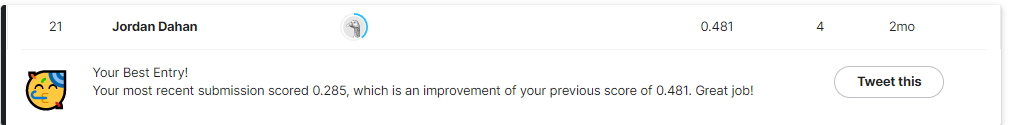    
* Maximum number of detections in each sequence according to conf> 0.9  
    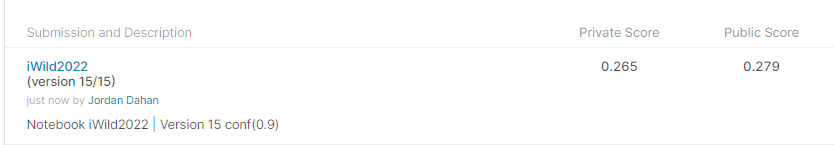
* Maximum number of detections in each sequence according to conf> 0.95  
    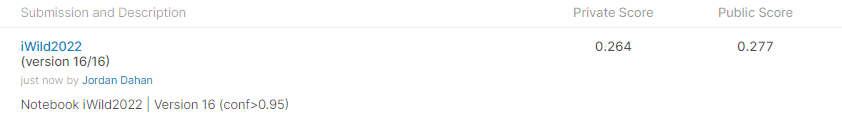
* Maximum number of detections in each sequence according to conf> 0.97   
    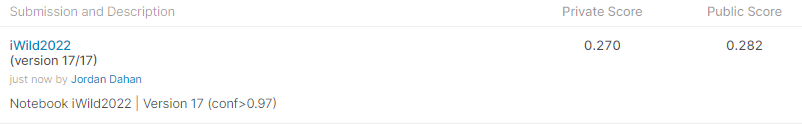


* As you can see - when the solution is to count the number of maximum detections of the megadetector model, the best results come when extracting the detections with conf> 0.95



## Solution 2: using Object-Tracker-Model


### Intro to Tracking
Tracking in deep learning is the task of predicting the positions of objects throughout a video using their spatial as well as temporal features. More technically, Tracking is getting the initial set of detections, assigning unique ids, and tracking them throughout frames of the video (or sequence of frames) feed while maintaining the assigned ids. Tracking is generally a two-step process:  
    **1. A detection module for target localization: The module responsible for detecting and localization of the object in the frame using some object detector like YOLOv4, CenterNet, etc (In our case- the detections is given part of db).**  
    **2. A motion predictor: This module is responsible for predicting the future motion of the object using its past information.**

### Types of Trackers

1. **Single Object Tracker**- These types of trackers track only a single object even if there are many other objects present in the frame. (We will not use here).
2. **Multiple Object Tracker -**
These types of trackers can track multiple objects present in a frame. Some of the algorithms include DeepSORT, JDE, and CenterTrack which are very powerful algorithms and handle most of the challenges faced by trackers. (We will present the idea below).  

DeepSORT: [arXiv:1703.07402](https://arxiv.org/abs/1703.07402)  
Centroid: [centroid tracking](https://pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/)

### Centroid-Tracker

  0%|          | 27/11028 [00:00<02:57, 61.92it/s]

height                                    id  \
0    1536  9773fd0a-21bc-11ea-a13a-137349068a90   
1    1536  905518c4-21bc-11ea-a13a-137349068a90   
2    1536  952100c0-21bc-11ea-a13a-137349068a90   
3    1536  87a353e4-21bc-11ea-a13a-137349068a90   
4    1536  9557f666-21bc-11ea-a13a-137349068a90   
5    1536  9800e47c-21bc-11ea-a13a-137349068a90   
6    1536  92b2b27a-21bc-11ea-a13a-137349068a90   
7    1536  97adf12c-21bc-11ea-a13a-137349068a90   
8    1536  8e3a8e66-21bc-11ea-a13a-137349068a90   
9    1536  964d7fdc-21bc-11ea-a13a-137349068a90   

                                 seq_id  location  width  \
0  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
1  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
2  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
3  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
4  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
5  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
6  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
7  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
8  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
9  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   

                  datetime                                 file_name  \
0  2013-02-17 07:25:15.000  9773fd0a-21bc-11ea-a13a-137349068a90.jpg   
1  2013-02-17 07:25:21.000  905518c4-21bc-11ea-a13a-137349068a90.jpg   
2  2013-02-17 07:25:40.000  952100c0-21bc-11ea-a13a-137349068a90.jpg   
3  2013-02-17 07:25:47.000  87a353e4-21bc-11ea-a13a-137349068a90.jpg   
4  2013-02-17 07:25:53.000  9557f666-21bc-11ea-a13a-137349068a90.jpg   
5  2013-02-17 07:26:22.000  9800e47c-21bc-11ea-a13a-137349068a90.jpg   
6  2013-02-17 07:26:28.000  92b2b27a-21bc-11ea-a13a-137349068a90.jpg   
7  2013-02-17 07:26:35.000  97adf12c-21bc-11ea-a13a-137349068a90.jpg   
8  2013-02-17 07:26:53.000  8e3a8e66-21bc-11ea-a13a-137349068a90.jpg   
9  2013-02-17 07:27:00.000  964d7fdc-21bc-11ea-a13a-137349068a90.jpg   

   seq_frame_num  seq_num_frames  sub_location  
0              0              10           NaN  
1              1              10           NaN  
2              2              10           NaN  
3              3              10           NaN  
4              4              10           NaN  
5              5              10           NaN  
6              6              10           NaN  
7              7              10           NaN  
8              8              10           NaN  
9              9              10           NaN

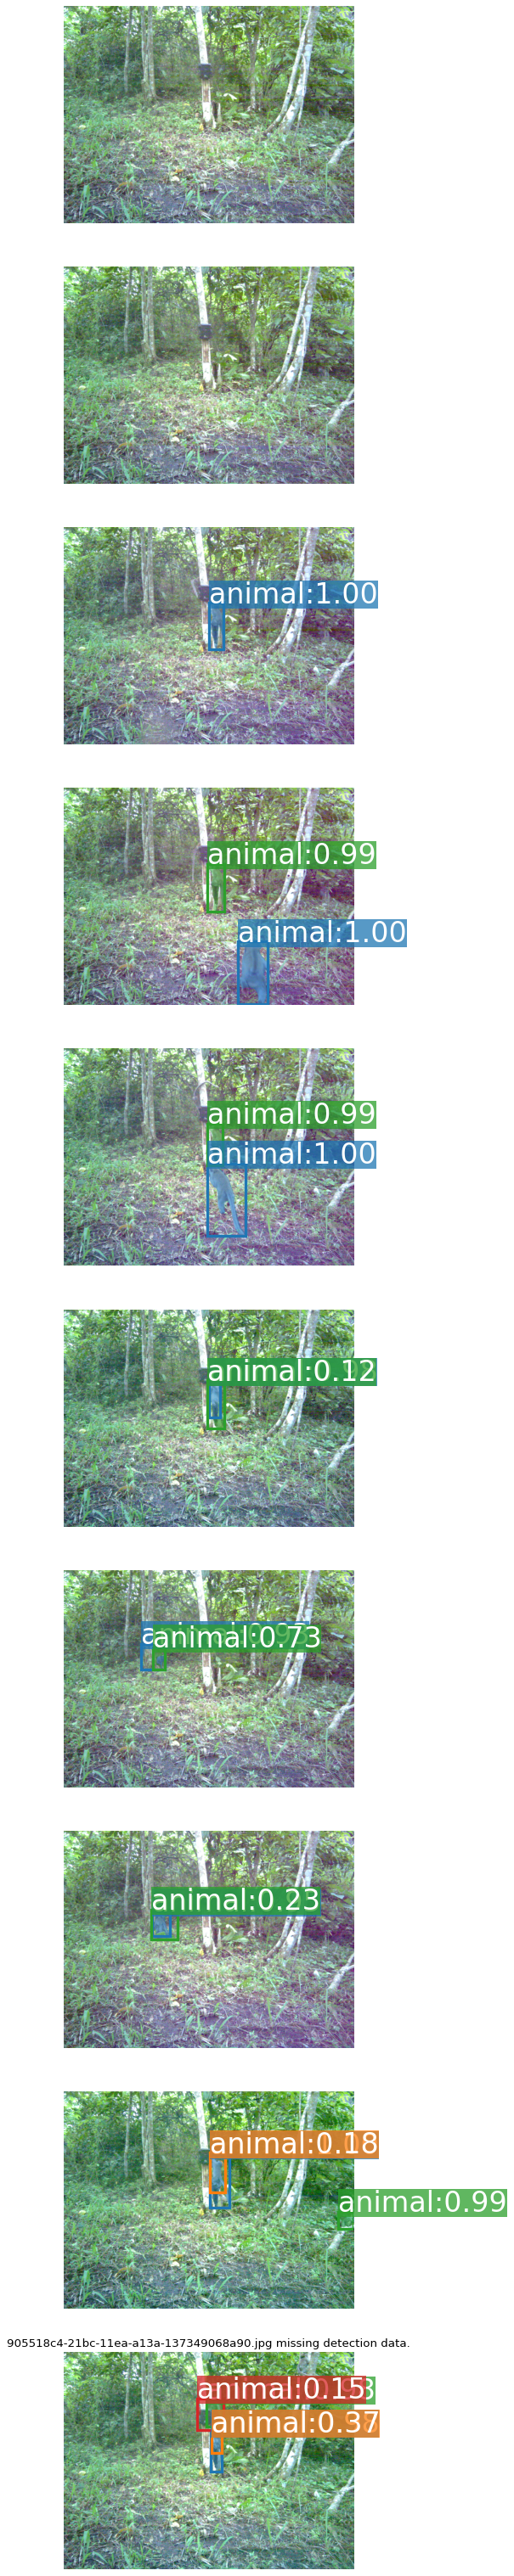

  0%|          | 34/11028 [00:16<2:30:59,  1.21it/s]

id_count = 2


height                                    id  \
0    1080  86e72872-21bc-11ea-a13a-137349068a90   
1    1080  878d5aee-21bc-11ea-a13a-137349068a90   
2    1080  8c5815a0-21bc-11ea-a13a-137349068a90   
3    1080  9266e106-21bc-11ea-a13a-137349068a90   
4    1080  8cc34848-21bc-11ea-a13a-137349068a90   
5    1080  8ce0cd28-21bc-11ea-a13a-137349068a90   
6    1080  889005e0-21bc-11ea-a13a-137349068a90   
7    1080  8aeb6a82-21bc-11ea-a13a-137349068a90   
8    1080  906ca250-21bc-11ea-a13a-137349068a90   
9    1080  98b6123e-21bc-11ea-a13a-137349068a90   

                                 seq_id  location  width  \
0  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
1  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
2  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
3  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
4  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
5  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
6  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
7  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
8  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
9  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   

                  datetime                                 file_name  \
0  2013-01-19 09:31:31.000  86e72872-21bc-11ea-a13a-137349068a90.jpg   
1  2013-01-19 09:31:32.000  878d5aee-21bc-11ea-a13a-137349068a90.jpg   
2  2013-01-19 09:31:33.000  8c5815a0-21bc-11ea-a13a-137349068a90.jpg   
3  2013-01-19 09:31:41.000  9266e106-21bc-11ea-a13a-137349068a90.jpg   
4  2013-01-19 09:31:42.000  8cc34848-21bc-11ea-a13a-137349068a90.jpg   
5  2013-01-19 09:31:43.000  8ce0cd28-21bc-11ea-a13a-137349068a90.jpg   
6  2013-01-19 09:31:49.000  889005e0-21bc-11ea-a13a-137349068a90.jpg   
7  2013-01-19 09:31:50.000  8aeb6a82-21bc-11ea-a13a-137349068a90.jpg   
8  2013-01-19 09:31:51.000  906ca250-21bc-11ea-a13a-137349068a90.jpg   
9  2013-01-19 09:31:52.000  98b6123e-21bc-11ea-a13a-137349068a90.jpg   

   seq_frame_num  seq_num_frames  sub_location  
0              0              10           NaN  
1              1              10           NaN  
2              2              10           NaN  
3              3              10           NaN  
4              4              10           NaN  
5              5              10           NaN  
6              6              10           NaN  
7              7              10           NaN  
8              8              10           NaN  
9              9              10           NaN

  0%|          | 43/11028 [00:25<2:29:45,  1.22it/s]

id_count = 2


  1%|          | 61/11028 [00:25<55:05,  3.32it/s]  

height                                    id  \
0    1536  87d975be-21bc-11ea-a13a-137349068a90   
1    1536  8b81d422-21bc-11ea-a13a-137349068a90   
2    1536  8fd14e36-21bc-11ea-a13a-137349068a90   
3    1536  91ff45d2-21bc-11ea-a13a-137349068a90   
4    1536  867837f0-21bc-11ea-a13a-137349068a90   
5    1536  90ade954-21bc-11ea-a13a-137349068a90   
6    1536  8e69aade-21bc-11ea-a13a-137349068a90   
7    1536  971156be-21bc-11ea-a13a-137349068a90   
8    1536  967df13a-21bc-11ea-a13a-137349068a90   
9    1536  905ccbd2-21bc-11ea-a13a-137349068a90   

                                 seq_id  location  width  \
0  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
1  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
2  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
3  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
4  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
5  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
6  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
7  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
8  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
9  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   

                  datetime                                 file_name  \
0  2014-07-07 05:22:03.000  87d975be-21bc-11ea-a13a-137349068a90.jpg   
1  2014-07-07 05:22:03.000  8b81d422-21bc-11ea-a13a-137349068a90.jpg   
2  2014-07-07 05:22:03.000  8fd14e36-21bc-11ea-a13a-137349068a90.jpg   
3  2014-07-07 05:22:03.000  91ff45d2-21bc-11ea-a13a-137349068a90.jpg   
4  2014-07-07 05:22:03.000  867837f0-21bc-11ea-a13a-137349068a90.jpg   
5  2014-07-07 05:22:03.000  90ade954-21bc-11ea-a13a-137349068a90.jpg   
6  2014-07-07 05:22:04.000  8e69aade-21bc-11ea-a13a-137349068a90.jpg   
7  2014-07-07 05:22:04.000  971156be-21bc-11ea-a13a-137349068a90.jpg   
8  2014-07-07 05:22:04.000  967df13a-21bc-11ea-a13a-137349068a90.jpg   
9  2014-07-07 05:22:04.000  905ccbd2-21bc-11ea-a13a-137349068a90.jpg   

   seq_frame_num  seq_num_frames  sub_location  
0              0              10           NaN  
1              1              10           NaN  
2              2              10           NaN  
3              3              10           NaN  
4              4              10           NaN  
5              5              10           NaN  
6              6              10           NaN  
7              7              10           NaN  
8              8              10           NaN  
9              9              10           NaN

  1%|          | 61/11028 [00:39<55:05,  3.32it/s]

  1%|          | 75/11028 [00:42<1:58:24,  1.54it/s]

id_count = 3


100%|██████████| 11028/11028 [02:58<00:00, 61.83it/s]


Id  Predicted
0      a91ebc18-0cd3-11eb-bed1-0242ac1c0002          1
1      a91d6764-0cd3-11eb-bed1-0242ac1c0002          1
2      91ccb676-21bc-11ea-a13a-137349068a90          0
3      386914ce-6fe2-11eb-844f-0242ac1c0002          0
4      988ae29e-21bc-11ea-a13a-137349068a90          0
...                                     ...        ...
11023  a918faee-0cd3-11eb-bed1-0242ac1c0002          1
11024  94284f52-21bc-11ea-a13a-137349068a90          0
11025  9912f080-21bc-11ea-a13a-137349068a90          0
11026  96fe10f4-21bc-11ea-a13a-137349068a90          0
11027  a91b0b90-0cd3-11eb-bed1-0242ac1c0002          1

[11028 rows x 2 columns]

4


In [6]:
                                                                                                                               #######  
class EuclideanDistTracker:
    def __init__(self):
        self.center_points = {}
        self.id_count = 0
    
    def update(self, objects_rect):
        """
        Parameters:
        -----------
        object_rect:  array of bounding box coordinates.
        --------
        Returns:
            list containing [x,y,w,h,object_id].
                x,y,w,h are the bounding box coordinates, and object_id is the id assigned to that particular bounding box.
        --------
        """
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx,cy = (x+w)/2, (y+h)/2
#             cx = (x + x + w) // 2 # Center x
#             cy = (y + y + h) // 2 # Center y
            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 25:
                    self.center_points[id] = (cx, cy)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids
    
def get_detections(detections_dict,height,width):
    detections = []
    for diction in detections_dict:
        if diction['conf'] > 0.95:
            detections.append(diction['bbox'])

    return detections 
    
tracker = EuclideanDistTracker()
submission_res_by_tracks = generate_zero_submission(seq_test.seq_id.unique())
i=0
for seq_id in tqdm(seq_test.seq_id.unique()):
    tracker.__init__()
    seq_frames = seq_test[seq_test.seq_id == seq_id].sort_values(by=['seq_frame_num']).reset_index( drop = True)
    for _,frame in seq_frames.iterrows():
        detections = get_detections(detection_test_map[frame['id']], frame['height'],frame['width'])
        boxes_ids = tracker.update(detections)
    if i < 3 and tracker.id_count > 1 :
        display(seq_frames)
        show_images_seq(seq_frames,detection_test_map,train=False)
        print(f'id_count = {tracker.id_count}')
        i+=1
        
    submission_res_by_tracks.loc[submission_res_by_tracks.Id == seq_id, 'Predicted'] = tracker.id_count

display(submission_res_by_tracks)
print(max(submission_res_by_tracks.Predicted))
submission_res_by_tracks.to_csv (r'res_by_tracks.csv', index = False, header=True) 


### Results: 
* As you remember, when the solution was the maximum number of consecutive identifications - the best result achieved:
    - Private = 0.264, Public = 0.277

Now with centroid-tracker model:
* with the limit of conf>0.95 on the detections:    
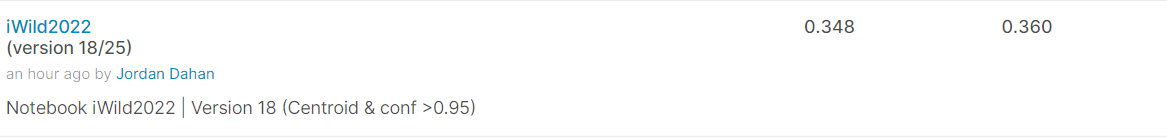  
    - Private = 0.348  Public = 0.360
* without the conf restriction on the detections:  

    - Private = 0.595 Public = 0.604


DEEP-SORT-TRACKER
https://pypi.org/project/deep-sort-realtime/

# Conclusion
* It is obvious that the performance of the object tracker is not as good as the counting heuristic. There could be several reasons for this.
- Also, in order to get better performance - we can produce the identifications ourselves by our own model.

    * It makes sense that the counting heuristic works best because we are counting animals in this project and since they were taken with a cameratrap (which takes many pictures in sequence when it detects movement) it could be that in one frame all the animals that passed by in sequence were captured. Therefore, the simple and working solution is to count the maximum number of identifications in the sequence of images.

* You can also try the deep sort tracker which uses a Kalman filter on the image sequences.
    * !git clone https://github.com/Jordan-me/DeepSort_Tracker.git
    * here is a code for start.

In [8]:

"""
This code taken from https://github.com/alcunha/iwildcam2021ufam
"""
!git clone https://github.com/Jordan-me/DeepSort_Tracker.git
from DeepSort_Tracker.deep_sort import nn_matching
from DeepSort_Tracker.deep_sort.detection import Detection
from DeepSort_Tracker.deep_sort.tracker import Tracker

max_cosine_distance = 0.2
nn_budget = None
def create_detections(annot, image_id):
    """
    This method return array of Detection objec (see class above)
    Parameters
    ----------
    annot : dataframe_like of bounding boxes for given images
    img_id : string desctibe image id  
    """
    detection_list = []
    for bbox in annot[image_id]:
        detection_list.append(Detection(bbox['bbox'],bbox['conf'],None))

    return detection_list

def run_deepsort_on_seq(detections_list, frames_ids):
    metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
    tracker = Tracker(metric)
    confirmed_tracks = []
    all_tracks = []

    for frame_id, detections in zip(frames_ids, detections_list):
        tracker.predict()
        for i in  detections:
            print(i.tlwh)
        tracker.update(detections)

    for track in tracker.tracks:
        if track.is_confirmed():
            confirmed_tracks.append(track.track_id)

        if track.time_since_update > 1:
            continue
        bbox = track.to_tlwh()
        all_tracks.append([frame_id, track.track_id, bbox[0], bbox[1], bbox[2], bbox[3]])
        
    confirmed_tracks = set(confirmed_tracks)
    print(confirmed_tracks)
    results = [track_bbox for track_bbox in all_tracks
             if track_bbox[1] in confirmed_tracks]
    print(results)
    return results

def track_iwildcam(data_set, annotations):
    tracks_list = []
    for seq_id in data_set.seq_id.unique():
        seq_info = data_set[data_set.seq_id == seq_id]
        seq_info = seq_info.sort_values(by=['seq_frame_num']) # [1st frame, 2st frame ,...]

        detections_list = []
        frames_ids = []
        for _, row in seq_info.iterrows():     # for each farme..
            detections = create_detections(annotations, row['id'])
            detections_list.append(detections)
            frames_ids.append(row['id'])

        results = run_deepsort_on_seq(detections_list, frames_ids)

    for bbox in results:
        bbox_info = {'seq_id': seq_id,
                     'img_id': bbox[0],
                     'track_id': seq_id + str(bbox[1]),
                     'bbox_tlwh': bbox[2:]      }
        tracks_list.append(bbox_info)
        
    return tracks_list

# confirmed_tracks = track_iwildcam(seq_test, detection_test_map)
# tracker = DeepSort(max_age=30, nn_budget=70, override_track_class=None)

Cloning into 'DeepSort_Tracker'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 145 (delta 81), reused 139 (delta 78), pack-reused 0
Receiving objects: 100% (145/145), 57.98 KiB | 1.04 MiB/s, done.
Resolving deltas: 100% (81/81), done.
